In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os

In [2]:
folder_path = '../data'
datasets = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]

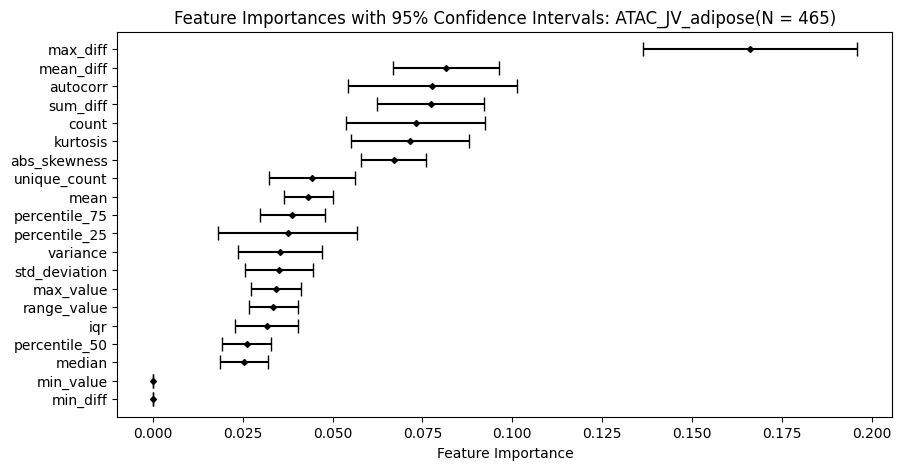

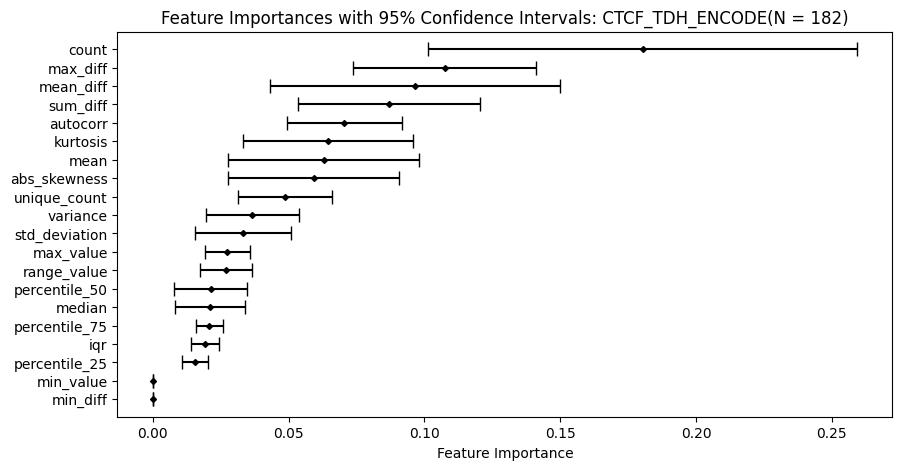

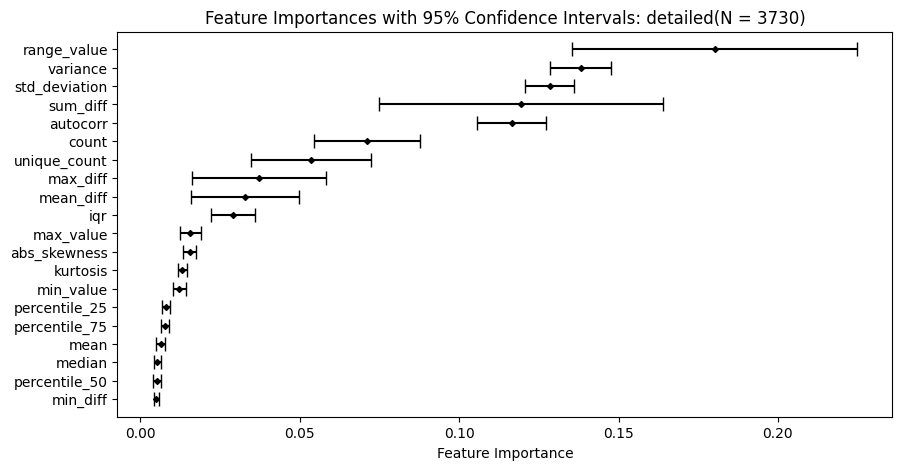

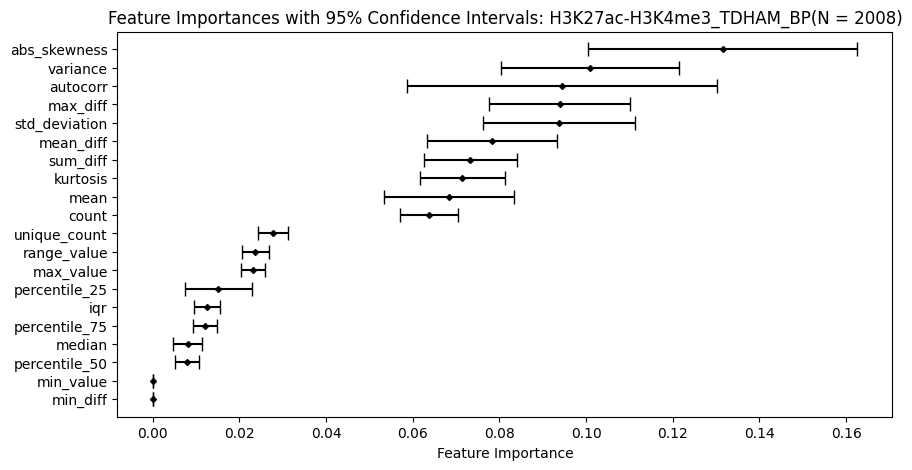

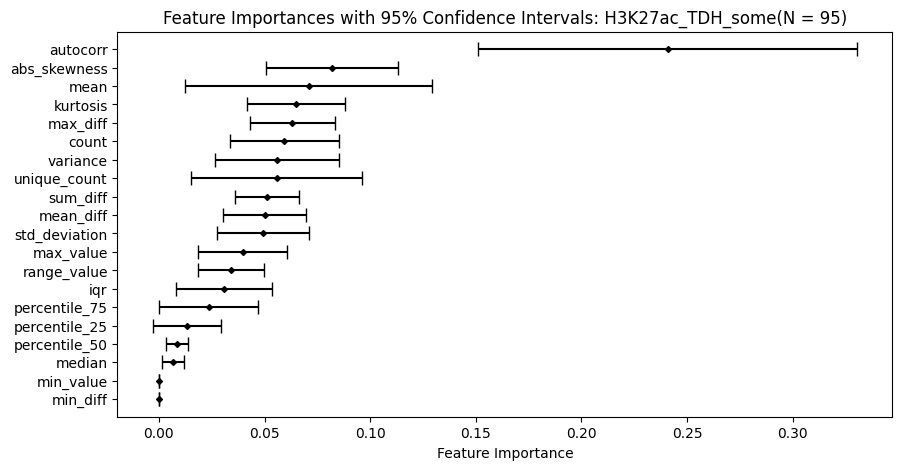

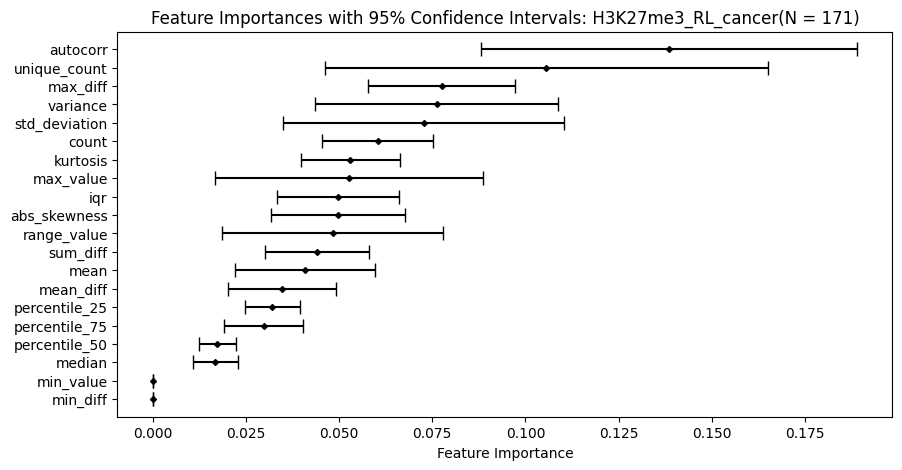

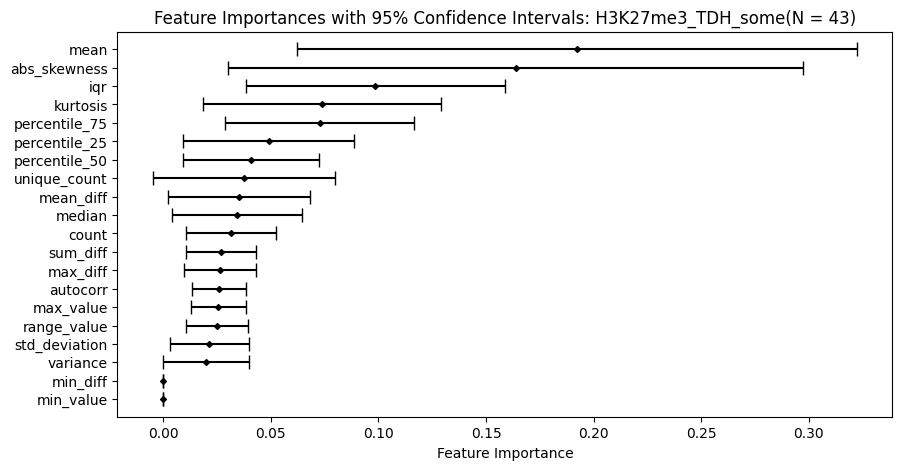

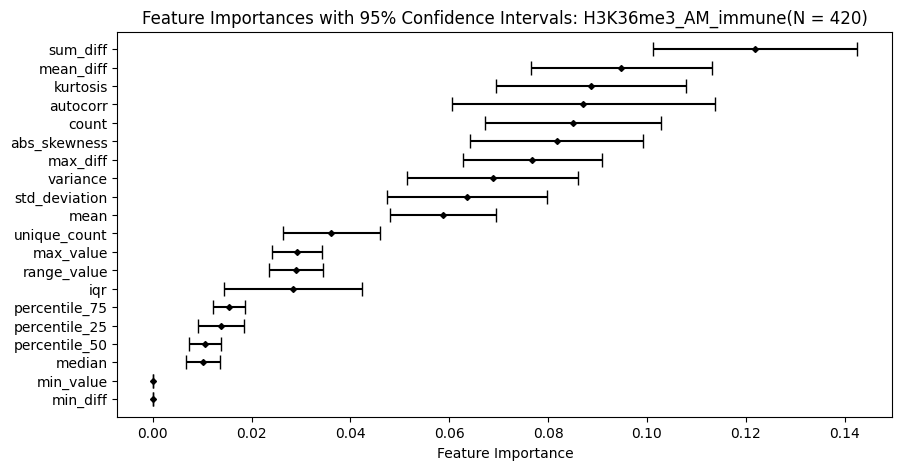

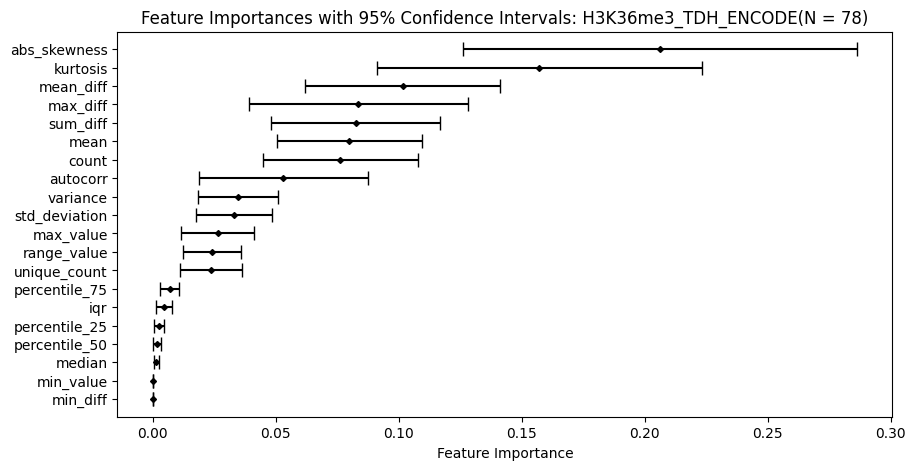

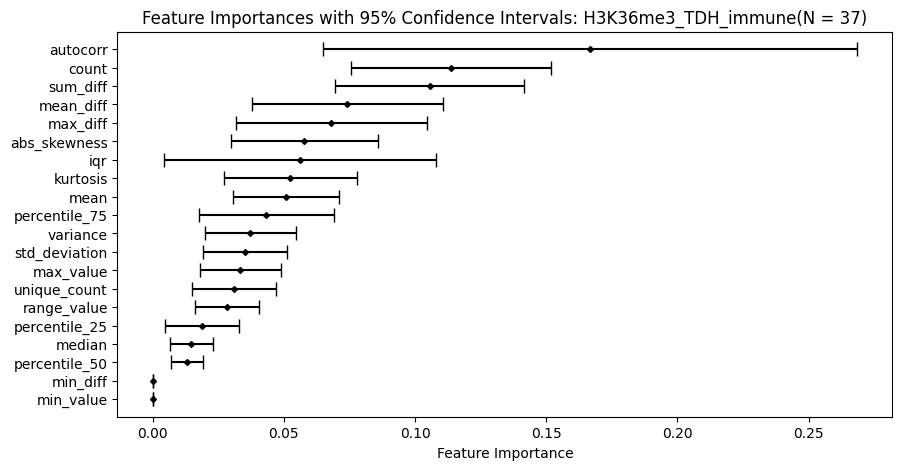

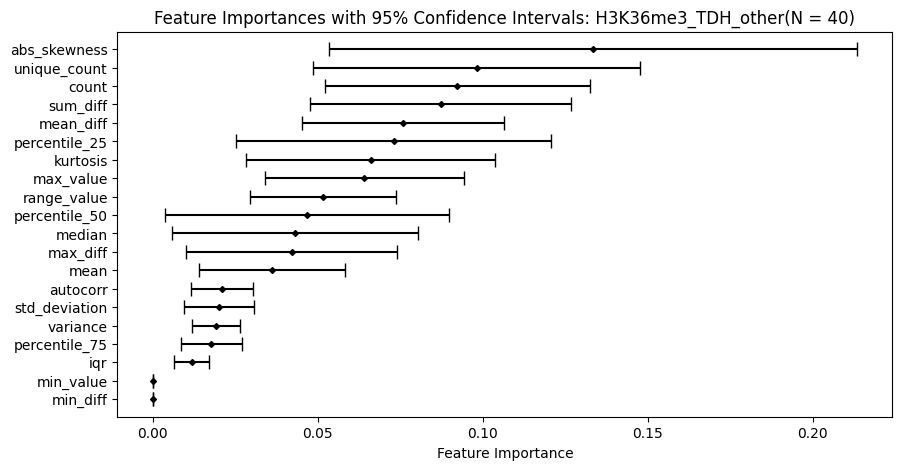

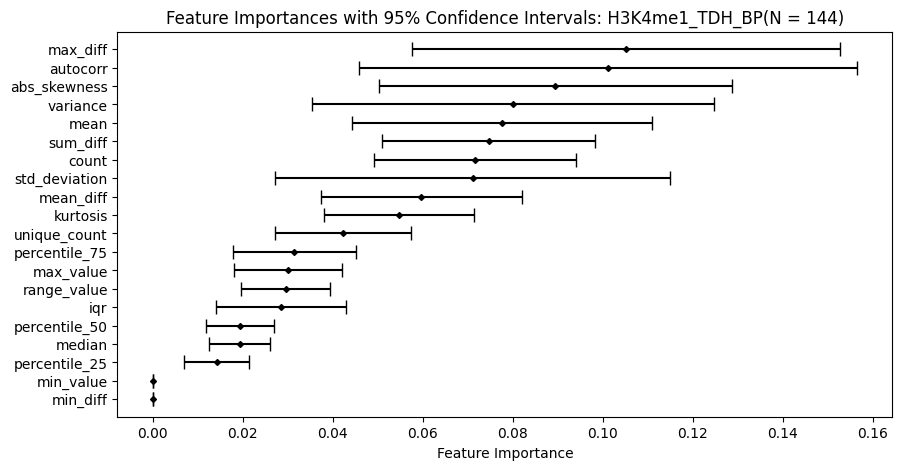

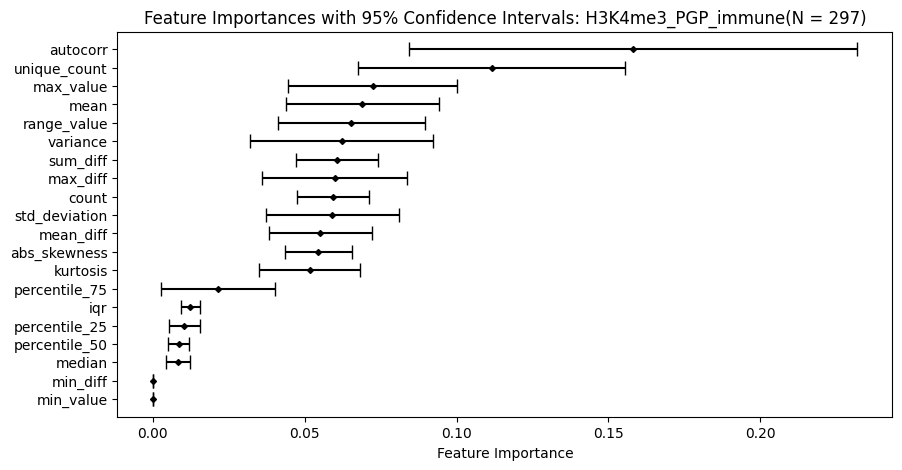

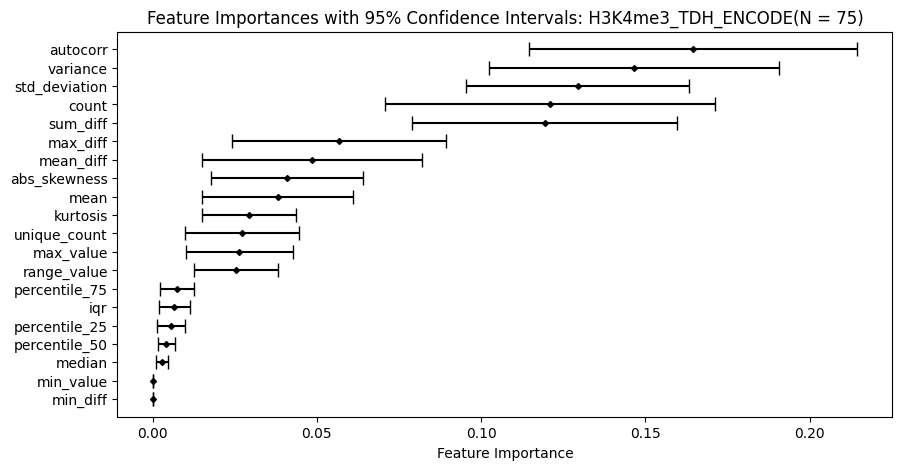

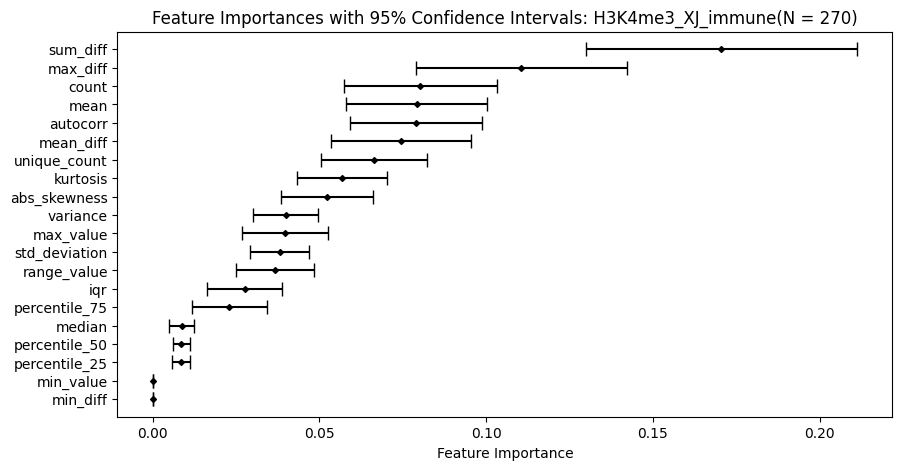

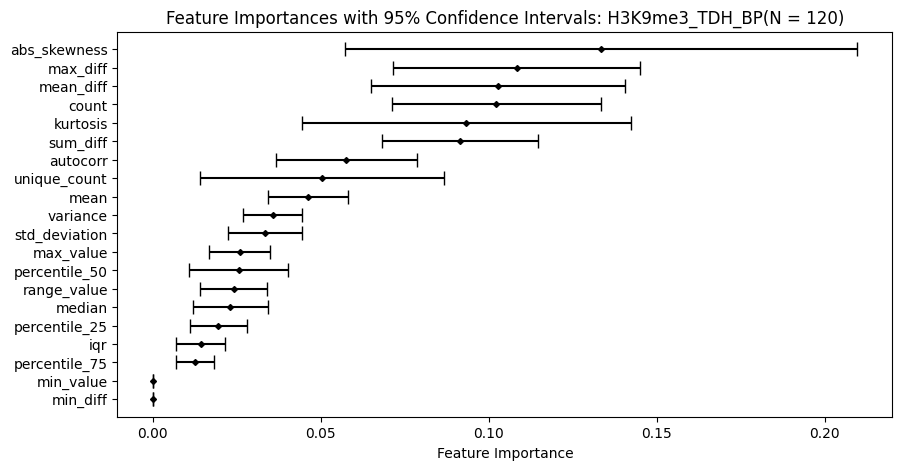

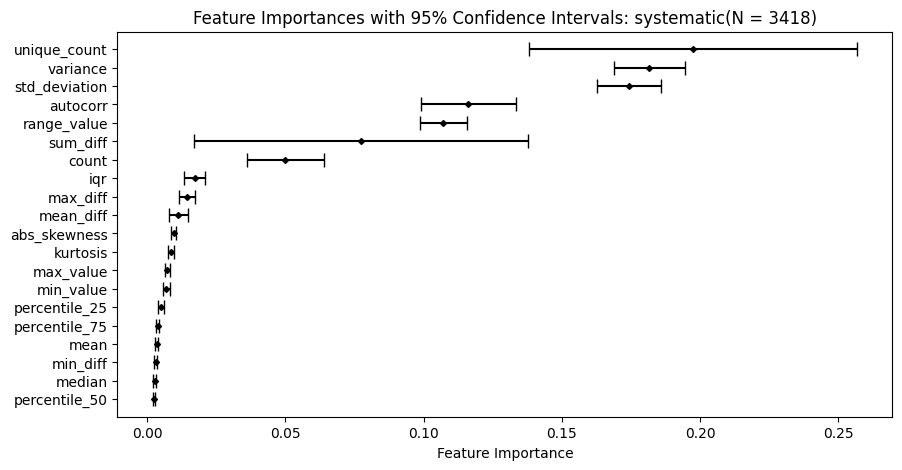

In [3]:
for dataset in datasets:
    feature_df = pd.read_csv('../data/' + dataset + '/features.csv')
    target_df = pd.read_csv('../data/' + dataset + '/target.csv')

    # Drop the specified columns from target_df
    target_df_filtered = target_df.drop(columns=['sequenceID'])

    # Concatenate feature_df and the filtered target_df
    feature_target_df = pd.concat([feature_df, target_df_filtered], axis=1)

    # Replace -inf with NaN for 'min.log.lambda'
    feature_target_df['min.log.lambda'] = feature_target_df['min.log.lambda'].replace(-np.inf, np.nan)

    # Replace inf with NaN for 'max.log.lambda'
    feature_target_df['max.log.lambda'] = feature_target_df['max.log.lambda'].replace(np.inf, np.nan)

    # Replace '#NAME?' with 0
    feature_target_df.replace('#NAME?', 0, inplace=True)

    X = feature_target_df[list(feature_target_df.columns)[1:21]]

    # Initialize arrays to store the importances for each bootstrap
    n_bootstraps = 10
    importances_min = np.zeros((n_bootstraps, X.shape[1]))
    importances_max = np.zeros((n_bootstraps, X.shape[1]))

    # Bootstrapping for min.log.lambda
    for i in range(n_bootstraps):
        # Drop NaNs specific to min.log.lambda
        df_min = feature_target_df.dropna(subset=['min.log.lambda'])
        X_min = df_min[list(df_min.columns)[1:21]]
        y_min = df_min['min.log.lambda']
        
        X_resampled, y_resampled = resample(X_min, y_min)  # Create a bootstrap sample
        rf_min = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_min.fit(X_resampled, y_resampled)           # Fit the model on the bootstrap sample
        importances_min[i, :] = rf_min.feature_importances_ # Store the feature importances

    # Bootstrapping for max.log.lambda
    for i in range(n_bootstraps):
        # Drop NaNs specific to max.log.lambda
        df_max = feature_target_df.dropna(subset=['max.log.lambda'])
        X_max = df_max[list(df_max.columns)[1:21]]
        y_max = df_max['max.log.lambda']
        
        X_resampled, y_resampled = resample(X_max, y_max)  # Create a bootstrap sample
        rf_max = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_max.fit(X_resampled, y_resampled)           # Fit the model on the bootstrap sample
        importances_max[i, :] = rf_max.feature_importances_ # Store the feature importances

    # Calculate the mean importances and confidence intervals for both targets
    mean_importances_min = np.mean(importances_min, axis=0)
    std_importances_min = np.std(importances_min, axis=0)
    lower_bound_min = mean_importances_min - std_importances_min
    upper_bound_min = mean_importances_min + std_importances_min

    mean_importances_max = np.mean(importances_max, axis=0)
    std_importances_max = np.std(importances_max, axis=0)
    lower_bound_max = mean_importances_max - std_importances_max
    upper_bound_max = mean_importances_max + std_importances_max

    # Average the feature importances and confidence intervals
    mean_importances = (mean_importances_min + mean_importances_max) / 2
    lower_bound = (lower_bound_min + lower_bound_max) / 2
    upper_bound = (upper_bound_min + upper_bound_max) / 2

    # Sort the indices based on mean_importances
    sorted_indices = np.argsort(mean_importances)

    # Sort the data accordingly
    sorted_mean_importances = mean_importances[sorted_indices]
    sorted_lower_bound = lower_bound[sorted_indices]
    sorted_upper_bound = upper_bound[sorted_indices]
    sorted_features = X.columns[sorted_indices]

    plt.figure(figsize=(10, 5))
    plt.errorbar(sorted_mean_importances, sorted_features, 
                xerr=[sorted_mean_importances - sorted_lower_bound, 
                      sorted_upper_bound - sorted_mean_importances], 
                fmt='D', color='black', ecolor='black', capsize=5, markersize=3)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances with 95% Confidence Intervals' + ": " + dataset + "(N = " + str(feature_target_df.shape[0]) + ")")
    plt.savefig("../figs/RF_Regression/" + dataset + ".png")
    plt.show()